/home/purzelrakete/src/github.com/feldberlin/deepspeech/.venv/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '
/home/purzelrakete/src/github.com/feldberlin/deepspeech/.venv/lib/python3.7/site-packages/torchaudio/compliance/kaldi.py:574: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  fft = torch.rfft(strided_input, 1, normalized=False, onesided=True)


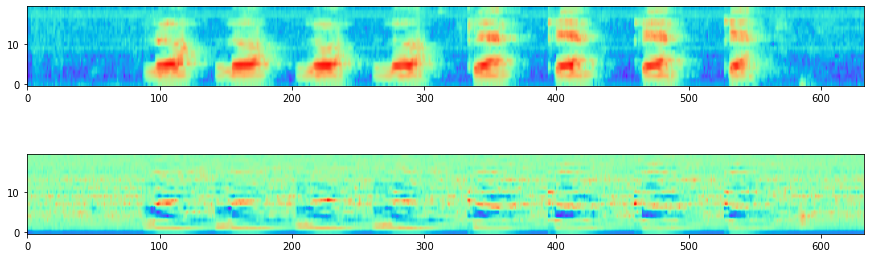

In [1]:
import torchaudio
yesno_raw = torchaudio.datasets.YESNO('.', download=True)

# Let's see what the spectrogram looks like
fbank = torchaudio.compliance.kaldi.fbank(yesno_raw[0][0], sample_frequency=yesno_raw[0][1], num_mel_bins=20)
mfcc = torchaudio.compliance.kaldi.mfcc(yesno_raw[0][0], sample_frequency=yesno_raw[0][1], num_mel_bins=20, num_ceps=20)
%matplotlib inline
import matplotlib.pyplot as plot
plot.rcParams["figure.figsize"] = (15,5)
plot.subplot(211)
plot.imshow(fbank.transpose(0,1), cmap='rainbow', origin='lower', aspect=3)
plot.subplot(212)
plot.imshow(mfcc.transpose(0,1), cmap='rainbow', origin='lower', aspect=3)

In [2]:
import torchaudio
import numpy as np
from torch.utils.data import Dataset
import math
class YesNoDataset(Dataset):
    def __init__(self, root):
        self.raw = torchaudio.datasets.YESNO(root, download=False)
        self.target_map = [[3, 4], [6, 2, 5]]
        self.left_context = 3
        self.right_context = 3
        self.max_input_length = 1200
        self.max_target_length = 40

    def __getitem__(self, index):
        wave_form, rate, label = self.raw[index]
        features = torchaudio.compliance.kaldi.mfcc(wave_form, sample_frequency=rate, num_mel_bins=20, num_ceps=20)
        targets = self.map_targets(label)

        inputs_length = np.array(features.shape[0]).astype(np.int64)
        targets_length = np.array(targets.shape[0]).astype(np.int64)
        features = self.pad(features, self.max_input_length).astype(np.float32)
        targets = self.pad(targets, self.max_target_length).astype(np.int64).reshape(-1)
        
        return features, inputs_length, targets, targets_length

    def __len__(self):
        return len(self.raw)
    
    def map_targets(self, label):
        targets = []
        for idx, word in enumerate(label):
            targets.extend(self.target_map[word])
            if (idx < len(label) - 1) : targets.append(1) 
        return np.array(targets)
    
    def pad(self, inputs, max_length):
        dim = len(inputs.shape)
        if dim == 1:
            # padding targets
            pad_zeros_mat = np.zeros([1, max_length - inputs.shape[0]], dtype=np.int32)
            padded_inputs = np.column_stack([inputs.reshape(1, -1), pad_zeros_mat])
        elif dim == 2:
            # padding inputs
            feature_dim = inputs.shape[1]
            pad_zeros_mat = np.zeros([max_length - inputs.shape[0], feature_dim])
            padded_inputs = np.row_stack([inputs, pad_zeros_mat])
        return padded_inputs

In [3]:
yesno_data = YesNoDataset('.')

In [4]:
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
indices = list(range(len(yesno_data)))
# np.random.shuffle(indices)
train_indices, test_indices = indices[:50], indices[50:]
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)
training_data = DataLoader(yesno_data, batch_size=3, shuffle=False, num_workers=0, sampler=train_sampler)
test_data = DataLoader(yesno_data, batch_size=1, shuffle=False, num_workers=0, sampler=test_sampler)

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F


def resize(lens):
    return (lens / 3.0).ceil().int() - 2


class CTC(nn.Module):
    def __init__(self):
        super(CTC, self).__init__()
        self.conv = nn.Conv2d(1, 100, stride=3, kernel_size=(26, 7))
        self.rnn = nn.RNN(input_size=100, hidden_size=100, num_layers=1, bidirectional=True, batch_first=True)
        self.output = nn.Linear(200, 7, bias=True)
        self.loss_fn = nn.CTCLoss()

    def forward(self, inputs, inputs_length, targets, targets_length):
        inputs = F.pad(inputs, (3, 3, 0, 0)).permute(0, 2, 1).unsqueeze(1)        
        # whats N, C, H, W, outputs N, C, 1, W
        inputs = self.conv(inputs)
        # goes to N, W, C
        inputs = torch.squeeze(inputs, 2).permute(0, 2, 1)
        outputs, _ = self.rnn(inputs)
        logits = self.output(outputs).log_softmax(2)
        logits = logits.transpose(0, 1).contiguous()
        targets, inputs_length, targets_length = targets.int(), inputs_length.int(), targets_length.int()
        inputs_length = resize(inputs_length)
        loss = self.loss_fn(logits, targets, inputs_length, targets_length)
        return loss

    def recognize(self, inputs):
        dic = ['', ' ', 'E', 'N', 'O', 'S', 'Y']
        if (len(inputs.shape) == 2):
            inputs = torch.unsqueeze(inputs, 0)
            
        inputs = F.pad(inputs, (3, 3, 0, 0)).permute(0, 2, 1).unsqueeze(1)        
        inputs = self.conv(inputs)
        inputs = torch.squeeze(inputs, 2).permute(0, 2, 1)

        outputs, _ = self.rnn(inputs)
        logits = self.output(outputs).softmax(2).detach()
        rdigit = []
        for logit in logits[0]:
            pred = int(torch.argmax(logit, dim=0).item())
            if pred != 0:
                if len(rdigit) > 0 and pred == rdigit[-1]:
                    continue
                rdigit.append(pred)
        result = ''.join([dic[x] for x in rdigit])
        return result, logits

device = 'cpu'
if torch.cuda.is_available():
    device = torch.cuda.current_device()

torch.cuda.manual_seed(20200513)
model = CTC()
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.006, momentum=0.9, weight_decay=0)

In [6]:
def train(epoch, model, training_data, optimizer):
    model.train()
    total_loss = 0  # track loss
    device = 'cpu'
    if torch.cuda.is_available():
        device = torch.cuda.current_device()

    for step, (inputs, inputs_length, targets, targets_length) in enumerate(training_data):
        # copy data to gpu device
        inputs, inputs_length = inputs.to(device), inputs_length.cpu()
        targets, targets_length = targets.to(device), targets_length.to(device)
        max_inputs_length = inputs_length.max().item()
        max_targets_length = targets_length.max().item()
        inputs = inputs[:, :max_inputs_length, :]
        targets = targets[:, :max_targets_length]

        # real thing
        optimizer.zero_grad()
        loss = model(inputs, inputs_length, targets, targets_length)
        loss = torch.mean(loss)
        loss.backward()
        total_loss += loss.item()
        nn.utils.clip_grad_norm_(model.parameters(), 200)
        optimizer.step()
        avg_loss = total_loss / (step + 1)
    print('epoch {0}: avg_loss {1}'.format(epoch, avg_loss))

In [7]:
for epoch in range(1, 100):
    train(epoch, model, training_data, optimizer)

epoch 1: avg_loss 2.773635702974656
epoch 2: avg_loss 0.9893299551571116
epoch 3: avg_loss 0.5841378254048964
epoch 4: avg_loss 0.2710527374463923
epoch 5: avg_loss 0.17253702703644247
epoch 6: avg_loss 0.13839959221727707
epoch 7: avg_loss 0.12550237906329773
epoch 8: avg_loss 0.11051835820955389
epoch 9: avg_loss 0.10600301579517477
epoch 10: avg_loss 0.10159789727014654
epoch 11: avg_loss 0.0912876468809212
epoch 12: avg_loss 0.08307228193563573
epoch 13: avg_loss 0.07752820498803083
epoch 14: avg_loss 0.07485398978871458
epoch 15: avg_loss 0.07042079966734438
epoch 16: avg_loss 0.06923976409084656
epoch 17: avg_loss 0.06355990787201068
epoch 18: avg_loss 0.05926323769723668
epoch 19: avg_loss 0.053622973973260206
epoch 20: avg_loss 0.05457765850074151
epoch 21: avg_loss 0.0526454652495244
epoch 22: avg_loss 0.058001315330757815
epoch 23: avg_loss 0.04959647554685088
epoch 24: avg_loss 0.043262798886965305
epoch 25: avg_loss 0.04170752623501946
epoch 26: avg_loss 0.03903721974176519

In [8]:
test = next(iter(test_data))
model.eval()
result, logits = model.recognize(test[0].cuda())
print(result)

 YES YES YES NO YES NO YES YES


In [9]:
dic = ['', ' ', 'E', 'N', 'O', 'S', 'Y']
label = ''.join([dic[x] for x in test[2][0]])
print(label)

YES YES YES NO YES NO YES YES


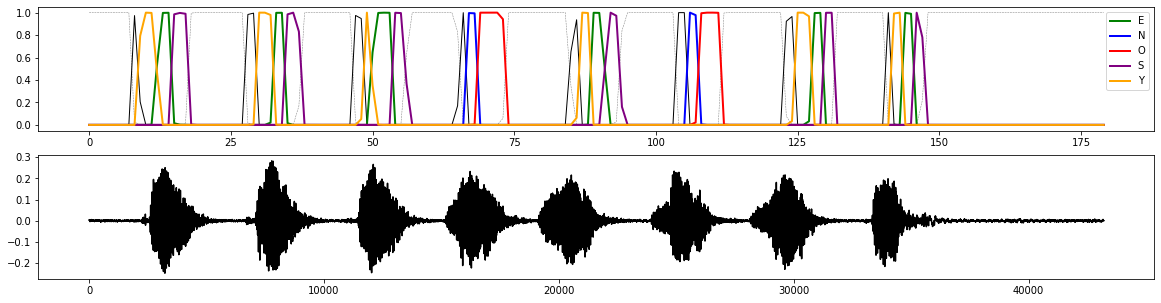

In [10]:
import matplotlib.pyplot as plot
probs = logits[0].transpose(0, 1).cpu().numpy()
show_start = 20
show_end = 200
plot.rcParams["figure.figsize"] = (20,5)
plot.subplot(211)
plot.plot(probs[0][show_start:show_end], '--', color='gray', linewidth=0.5)
plot.plot(probs[1][show_start:show_end], color='black', linewidth=1)
plot.plot(probs[2][show_start:show_end], color='green', linewidth=2, label='E')
plot.plot(probs[3][show_start:show_end], color='blue', linewidth=2, label='N')
plot.plot(probs[4][show_start:show_end], color='red', linewidth=2, label='O')
plot.plot(probs[5][show_start:show_end], color='purple', linewidth=2, label='S')
plot.plot(probs[6][show_start:show_end], color='orange', linewidth=2, label='Y')
plot.legend()
plot.subplot(212)
yesno_raw = torchaudio.datasets.YESNO('.', download=False)
for raw in yesno_raw:
    if raw[2] == [1, 1, 1, 0, 0, 0, 0, 1]:
        wave = raw[0]
        break
plot.plot(wave[0][(show_start*30*8):(show_end*30*8)], color='black')